# Example Map Plotting

In [ ]:
# By line: RRB 2020-07-20
# Script aims to:
# - Load a netCDF file
# - Extract one variable: CO
# - Calculate column values: load model pressure, multiply by ppb -> column conversion factor
# - Add cyclic point
# - Create contour plot of variable as world map with coastlines
# - Customize contours and colorbar
# - Add axes labels
# - Add grid lines

### At the start of a Jupyter notebook you need to import all modules that you will use.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                 # For plotting maps
import cartopy.feature as cfeature         # For plotting maps
from cartopy.util import add_cyclic_point  # For plotting maps
from pathlib import Path                   # System agnostic paths
import xarray as xr                        # For loading the data arrays
import numpy as np                         # For array creation and calculations

### Define the directories and file of interest for your results.

In [16]:
result_dir = Path("/home/buchholz/Documents/code_database/untracked/my-notebook/CAM_Chem_examples")
file = "CAM_chem_merra2_FCSD_1deg_QFED_monthoutput_CO_201801.nc"
file_to_open = result_dir / file
#the netcdf file is now held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
nc_load = xr.open_dataset(file_to_open)
#to see what the netCDF file contains, uncomment below
#nc_load

### Extract the variable of choice at the time and level of choice.

In [90]:
#extract variable
var_sel = nc_load['CO'].isel(time=0)
#print(var_sel)

#select the surface level at a specific time and convert to ppbv from vmr
#select the surface level for an average over three times and convert to ppbv from vmr
var_sel = var_sel*1e09 # 10-9 to ppb
print(var_sel.shape)

#extract grid variables
lat = var_sel.coords['lat']
lon = var_sel.coords['lon']

(56, 192, 288)


### Define constants for converting to column amounts.

In [115]:
#-------------------------------
#CONSTANTS and conversion factor
#-------------------------------
NAv = 6.0221415e+23                       #--- Avogadro's number
g = 9.81                                  #--- m/s - gravity
MWair = 28.94                             #--- g/mol
xp_const = (NAv* 10)/(MWair*g)*1e-09      #--- scaling factor for turning vmr into pcol
                                          #--- (note 1*e-09 because in ppb)

### Create 3d Pressure array.
Calculates pressures at each hybrid level using the formula: p(k) = a(k)*p0 + b(k)*ps. 

In [122]:
# Load values to create true model pressure array
psurf = nc_load['PS'].isel(time=0)
hyai = nc_load['hyai']
hybi = nc_load['hybi']
p0 = nc_load['P0']
lev = var_sel.coords['lev']
num_lev = lev.shape[0]

# Initialize pressure edge arrays
mod_press_low = xr.zeros_like(var_sel)
mod_press_top = xr.zeros_like(var_sel)

# Calculate pressure edge arrays
# CAM-chem layer indices start at the top and end at the bottom
for i in range(num_lev):
    mod_press_top[i,:,:] = hyai[i]*p0 + hybi[i]*psurf
    mod_press_low[i,:,:] = hyai[i+1]*p0 + hybi[i+1]*psurf

# Delta P in hPa
mod_deltap = (mod_press_low - mod_press_top)/100
#print(mod_press_low[:,0,0])
#print(mod_press_top[:,0,0])
#print(mod_deltap[:,0,0])

### Calculate columns.

In [116]:
var_tcol = xr.dot(mod_deltap, xp_const*var_sel, dims=["lev"])

### Add cyclic point to avoid white stripe at lon=0.

In [117]:
var_tcol_cyc, lon_cyc = add_cyclic_point(var_tcol, coord=lon) 

### Plot the value over the globe.

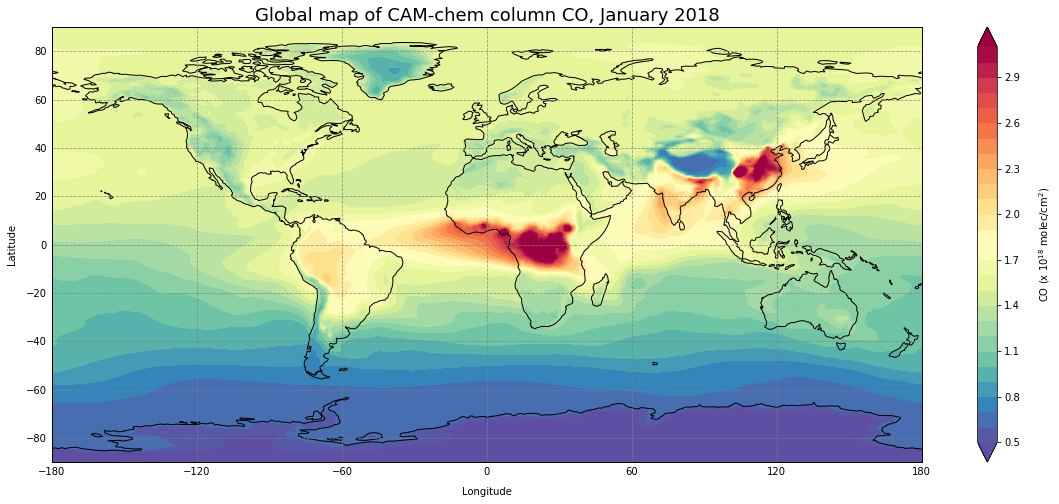

In [121]:
plt.figure(figsize=(20,8))

#Define projection
ax = plt.axes(projection=ccrs.PlateCarree())

#define contour levels
clev = np.arange(0.5, 3.2, 0.1)

#plot the data
plt.contourf(lon_cyc,lat,var_tcol_cyc/1e18,clev,cmap='Spectral_r',extend='both')

# add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Titles
# Main
plt.title("Global map of CAM-chem column CO, January 2018",fontsize=18)

# y-axis
ax.text(-0.04, 0.5, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
# x-axis
ax.text(0.5, -0.08, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
# legend
ax.text(1.15, 0.5, 'CO (x 10$^{18}$ molec/cm$^{2}$)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)

plt.colorbar()
plt.show() 